In [40]:
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_squared_log_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import warnings
warnings.filterwarnings('ignore')
from EDA_plots import *
from plot_style import *
from time_var import *
path = 'data'

In [41]:
df_sales_train = pd.read_csv(path+'/train.csv', parse_dates=['date'])
df_sales_test = pd.read_csv(path+'/test.csv', parse_dates=['date'])
df_trans = pd.read_csv(path+'/transactions.csv', parse_dates=['date'])
df_stores = pd.read_csv(path+'/stores.csv')
df_oil = pd.read_csv(path+'/oil.csv', parse_dates=['date'])

In [42]:
# daily sales totals needed for store analysis and additional features
total_daily_sales = (
    df_sales_train.drop(columns = 'onpromotion')
    .groupby(['date', 'store_nbr'])
    .sum()
    .reset_index()
#     .unstack('store_nbr')
)

stores_temp = pd.merge(df_trans, total_daily_sales, on=['date', 'store_nbr']).drop(columns="id")

# set up 4 new features:

# NOTE: sales is # items sold, not monetary amount, so this isn't really avg ticket size, but average amount of items sold per transaction
# 1) average ticket per transaction (common retail metric) - total daily sales divided by total daily transactions
stores_temp['avg_ticket'] = stores_temp['sales'] / stores_temp['transactions']

# 2) "old" store is one that has already opened and has sales on first (non holiday) date of data set
old_stores = stores_temp[stores_temp['date'] == '2013-01-02'].store_nbr.values
df_stores['old'] = df_stores['store_nbr'].isin(old_stores)

# 3) start date for store
df_stores['start_date'] = [stores_temp[stores_temp['store_nbr']==num]['date'].dt.date.min() for num in range(1,55)]
df_stores['start_date'] = pd.to_datetime(df_stores['start_date'])

# 4) wage: wages paid in public sector is True when on 15th or last day of month
stores_temp['wage'] = (stores_temp['date'].dt.is_month_end) | (stores_temp['date'].dt.day == 15)

daily_store_totals_df = pd.merge(stores_temp, df_stores, on='store_nbr')

In [43]:
holidays_events = pd.read_csv(
    path+"/holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',},
    parse_dates=['date'],
    infer_datetime_format=True,)

holidays_events['date'] = holidays_events['date'].replace({'2013-04-29':pd.to_datetime('2013-03-29')}) # 'Good Friday' mistake correction
holidays_events = holidays_events.set_index('date').to_period('D').sort_index() # note the sort after Good Friday correction

df_test = pd.read_csv(
    path+'/test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
 
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [44]:
%%time

store_sales = pd.read_csv(
    path+'/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,)

store_sales['date'] = store_sales.date.dt.to_period('D')
# store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index() # MultiIndex

# replace above MultiIndex line with the following 2 lines in order to get missing Christmas days
# as some algorithms later require filled out MultiIndex (even if just zeros), including the missing Christmas days
# (see https://stackoverflow.com/questions/62437346/add-missing-date-index-in-a-multiindex-dataframe)
m_index = pd.MultiIndex.from_product([store_sales["store_nbr"].unique(),
                                      store_sales["family"].unique(),
                                      pd.date_range(start="2013-1-1", end="2017-8-15", freq="D").to_period('D')] # to get missing Christmas Days
                                     ,names=["store_nbr","family", "date"])
store_sales = store_sales.set_index(["store_nbr","family", "date"]).reindex(m_index, fill_value=0).sort_index()


store_sales = store_sales.unstack(['store_nbr', 'family']).fillna(0) # there are lots
store_sales = store_sales.stack(['store_nbr', 'family'])
store_sales = store_sales[['sales','onpromotion']] # reorder columns to be in the expected order

Wall time: 1min 22s


In [45]:
calendar = pd.DataFrame(index=pd.date_range('2013-01-01', '2017-08-31')).to_period('D')
calendar['dofw'] = calendar.index.dayofweek

df_hev = holidays_events[holidays_events.locale == 'National'] # National level only for simplicity
df_hev = df_hev.groupby(df_hev.index).first() # Keep one event only

calendar['wd'] = True
calendar.loc[calendar.dofw > 4, 'wd'] = False
calendar = calendar.merge(df_hev, how='left', left_index=True, right_index=True)

calendar.loc[calendar.type == 'Bridge'  , 'wd'] = False
calendar.loc[calendar.type == 'Work Day', 'wd'] = True
calendar.loc[calendar.type == 'Transfer', 'wd'] = False
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = False
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True ), 'wd'] = True

# Transferred column True: holiday officially falls on that calendar day, but was moved to another date by the government.
# type Transfer: day transfer (True) holiday is actually celebrated (i.e. 8/10/17 --> 8/11/17 Primer Grito de Independencia)

# type Bridge: extra days that are added to a holiday (e.g., to extend the break across a long weekend).
# These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

# type Additional:  days added to a regular calendar holiday such as happens around Christmas

In [46]:
calendar.tail(5)

dofw     wd type locale locale_name description transferred
2017-08-27     6  False  NaN    NaN         NaN         NaN         NaN
2017-08-28     0   True  NaN    NaN         NaN         NaN         NaN
2017-08-29     1   True  NaN    NaN         NaN         NaN         NaN
2017-08-30     2   True  NaN    NaN         NaN         NaN         NaN
2017-08-31     3   True  NaN    NaN         NaN         NaN         NaN

In [47]:
holidays_events.loc[full_train_start_day:test_end_day]

type    locale locale_name  \
date                                         
2015-06-23   Holiday     Local    Guaranda   
2015-06-25   Holiday     Local     Machala   
2015-06-25   Holiday  Regional    Imbabura   
2015-06-25   Holiday     Local   Latacunga   
2015-07-03   Holiday     Local   El Carmen   
...              ...       ...         ...   
2017-08-05   Holiday     Local  Esmeraldas   
2017-08-10   Holiday  National     Ecuador   
2017-08-11  Transfer  National     Ecuador   
2017-08-15   Holiday     Local    Riobamba   
2017-08-24   Holiday     Local      Ambato   

                                       description  transferred  
date                                                             
2015-06-23               Cantonizacion de Guaranda        False  
2015-06-25                    Fundacion de Machala        False  
2015-06-25           Provincializacion de Imbabura        False  
2015-06-25              Cantonizacion de Latacunga        False  
2015-07-03              Cantonizacion de El Carmen        False  
...                                            ...          ...  
2017-08-05                 Fundacion de Esmeraldas        False  
2017-08-10           Primer Grito de Independencia         True  
2017-08-11  Traslado Primer Grito de Independencia        False  
2017-08-15                   Fundacion de Riobamba        False  
2017-08-24                     Fundacion de Ambato        False  

[153 rows x 5 columns]

In [48]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None
        self.stack_cols = None
        self.y_resid = None

    def fit1(self, X_1, y, stack_cols=None):
        self.model_1.fit(X_1, y) # train model 1
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1), # predict from model 1
            index=X_1.index,
            columns=y.columns,
        )
        self.y_resid = y - y_fit # residuals from model 1, which X2 may want to access to create lag (or other) features
        self.y_resid = self.y_resid.stack(stack_cols).squeeze()  # wide to long
        
    def fit2(self, X_2, first_n_rows_to_ignore, stack_cols=None):
        self.model_2.fit(X_2.iloc[first_n_rows_to_ignore*1782: , :], self.y_resid.iloc[first_n_rows_to_ignore*1782:]) # Train model_2
        self.y_columns = y.columns # Save for predict method
        self.stack_cols = stack_cols # Save for predict method

    def predict(self, X_1, X_2, first_n_rows_to_ignore):
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1.iloc[first_n_rows_to_ignore: , :]),
            index=X_1.iloc[first_n_rows_to_ignore: , :].index,
            columns=self.y_columns,
        )
        y_pred = y_pred.stack(self.stack_cols).squeeze()  # wide to long
#         display(X_2.iloc[first_n_rows_to_ignore*1782: , :]) # uncomment when debugging
        y_pred += self.model_2.predict(X_2.iloc[first_n_rows_to_ignore*1782: , :]) # Add model_2 predictions to model_1 predictions
        return y_pred.unstack(self.stack_cols)

In [49]:
# making this a seperate function keeps make_X1_features small
# might make sense to make dp into a BoostedHybrid Class variable

def make_dp_features(df):
    y = df.loc[:, 'sales']
    #fourier_a = CalendarFourier(freq='A', order=4)
    fourier_m = CalendarFourier(freq='M', order=4)
    dp = DeterministicProcess(
        index=y.index,
        constant=True,
        order=1,
        seasonal=True, # note how this generates terms Tue - Sun: s(2,7) through s(7,7) (trend column: Monday)
        additional_terms=[fourier_m],
        drop=True,
    )
    return y, dp


In [50]:
def make_X1_features(df, start_date, end_date, is_test_set=False):
    if is_test_set:
        X1 = df.rename_axis('date')
    else:
        y, dp = make_dp_features(df)
        X1 = dp.in_sample() # seasonal (weekly) and fourier (longer time frame) features are generated using DeterministicProcess
    
    # other features:
    
#     X1['wage_day'] = (X1.index.day == X1.index.daysinmonth) | (X1.index.day == 15) # wage day features seem better for XGBoost than linear regression
#     X1['wage_day_lag_1'] = (X1.index.day == 1) | (X1.index.day == 16)
    X1['NewYear'] = (X1.index.dayofyear == 1)
    X1['Christmas'] = (X1.index=='2016-12-25') | (X1.index=='2015-12-25') | (X1.index=='2014-12-25') | (X1.index=='2013-12-25')
    X1['wd']   = calendar.loc[start_date:end_date]['wd'].values
    X1['type'] = calendar.loc[start_date:end_date]['type'].values
    X1 = pd.get_dummies(X1, columns=['type'], drop_first=False)
# can experiment with dropping some of the dummy features if you think they might be useless or worse
# X1.drop(['type_Work Day', 'type_Event'], axis=1, inplace=True)
    
    if is_test_set:
        return X1
    else:
        return X1, y, dp

In [51]:
def encode_categoricals(df, columns):
    le = LabelEncoder()  # from sklearn.preprocessing
    for col in columns:
        df[col] = le.fit_transform(df[col])
    return df

def make_X2_lags(ts, lags, lead_time=1, name='y', stack_cols=None):
    ts = ts.unstack(stack_cols)
    df = pd.concat(
        {
            f'{name}_lag_{i}': ts.shift(i, freq="D") # freq adds i extra day(s) to end: only one extra day is needed so rest will be dropped
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)
    df = df.stack(stack_cols).reset_index()
    df = encode_categoricals(df, stack_cols)
    df = df.set_index('date').sort_values(by=stack_cols) # return sorted so can correctly compute rolling means (if desired)
    return df

def make_X2_features(df, y_resid):
    stack_columns = ['store_nbr', 'family']
    
#     # promo_lag features
    shifted_promo_df = make_X2_lags(df.squeeze(), lags=2, name='promo', stack_cols=['store_nbr', 'family'])
    shifted_promo_df['promo_mean_rolling_7'] = shifted_promo_df['promo_lag_1'].rolling(window=7, center=False).mean()
    shifted_promo_df['promo_median_rolling_91'] = shifted_promo_df['promo_lag_1'].rolling(window=91, center=False).median().fillna(method='bfill')
    shifted_promo_df['promo_median_rolling_162'] = shifted_promo_df['promo_lag_1'].rolling(window=162, center=False).median().fillna(method='bfill')
    # for rolling window medians, backfilling seems reasonable as medians shouldn't change too much. Trying min_periods produced wacky (buggy?) results
    
    # y_lag features
    shifted_y_df = make_X2_lags(y_resid, lags=2, name='y_res', stack_cols=stack_columns)
    shifted_y_df['y_mean_rolling_7'] = shifted_y_df['y_res_lag_1'].rolling(window=7, center=False).mean()
#     shifted_y_df['y_mean_rolling_14'] = shifted_y_df['y_res_lag_1'].rolling(window=14, center=False).mean()
#     shifted_y_df['y_mean_rolling_28'] = shifted_y_df['y_res_lag_1'].rolling(window=28, center=False).mean()
    shifted_y_df['y_median_rolling_91'] = shifted_y_df['y_res_lag_1'].rolling(window=91, center=False).median().fillna(method='bfill')
    shifted_y_df['y_median_rolling_162'] = shifted_y_df['y_res_lag_1'].rolling(window=162, center=False).median().fillna(method='bfill')
    
    # other features
    df = df.reset_index(stack_columns)
    X2 = encode_categoricals(df, stack_columns)
    
#     X2["day_of_m"] = X2.index.day  # day of month (label encloded) feature for learning seasonality
#     X2 = encode_categoricals(df, ['day_of_m']) # encoding as categorical has tiny impact with XGBoost
    X2["day_of_w"] = X2.index.dayofweek # does absolutely nothing alone
    X2 = encode_categoricals(df, ['day_of_w'])
    old_stores_strings = list(map(str, old_stores))
    X2['old'] = X2['store_nbr'].isin(old_stores_strings) # True if store had existing sales prior to training time period   
    X2['wage_day'] = (X2.index.day == X2.index.daysinmonth) | (X2.index.day == 15) # is it bad to have this in both X1 AND X2?
    X2['wage_day_lag_1'] = (X2.index.day == 1) | (X2.index.day == 16)
    X2['promo_mean'] = X2.groupby(['store_nbr', 'family'])['onpromotion'].transform("mean") + 0.000001
    X2['promo_ratio'] = X2.onpromotion / (X2.groupby(['store_nbr', 'family'])['onpromotion'].transform("mean") + 0.000001)
#     Can experiment with dropping basic feature but keeping something computed from it (i.e. drop y_res_lag_1 feature, keeping y_mean_rolling_7
#     shifted_y_df.drop('y_res_lag_1', axis=1, inplace=True)
#     shifted_promo_df.drop('promo_lag_1', axis=1, inplace=True)
#     X2.drop('onpromotion', axis=1, inplace=True)

    # if removing all lag features, then comment out the following two lines
    X2 = X2.merge(shifted_y_df, on=['date', 'store_nbr', 'family'], how='left')
    X2 = X2.merge(shifted_promo_df, on=['date', 'store_nbr', 'family'], how='left') # merges work if they are last line before return
    return X2

In [52]:
%%time

# unstack pivots MultiIndex to 54 x 33 = 1782 y columns
store_sales_in_date_range = store_sales.unstack(['store_nbr', 'family']).loc[full_train_start_day:full_train_end_day]

model = BoostedHybrid(model_1=mod_1, model_2=mod_2) # Boosted Hybrid

X_1, y, dp = make_X1_features(store_sales_in_date_range, full_train_start_day, full_train_end_day) # preparing X1 for hybrid model 1
model.fit1(X_1, y, stack_cols=['store_nbr', 'family']) # fit1 before make_X2_features, since X2 may want to create lag features from model.y_resid
X_2 = make_X2_features(store_sales_in_date_range # preparing X2 for hybrid model 2
                       .drop('sales', axis=1)
                       .stack(['store_nbr', 'family']),
                       model.y_resid)
model.fit2(X_2, max_lag, stack_cols=['store_nbr', 'family'])

y_pred = model.predict(X_1, X_2, max_lag).clip(0.0)

Wall time: 3min 8s


In [53]:
def truncateFloat(data):
    return tuple( ["{0:.2f}".format(x) if isinstance(x,float) else (x if not isinstance(x,tuple) else truncateFloat(x)) for x in data])

temp = X_2[(X_2.store_nbr == 1) & (X_2.family == 3)]
temp.iloc[max_lag: , :].apply(lambda s: truncateFloat(s)) # comment out next line if don't want to see nan rows

temp.apply(lambda s: truncateFloat(s)).head(10) # note that the fit method of BoostedHybrid class skips over nan rows

store_nbr  family  onpromotion  day_of_w    old  wage_day  \
date                                                                    
2015-06-16          1       3            1         1  False     False   
2015-06-17          1       3           26         2  False     False   
2015-06-18          1       3            1         3  False     False   
2015-06-19          1       3            2         4  False     False   
2015-06-20          1       3            0         5  False     False   
2015-06-21          1       3            1         6  False     False   
2015-06-22          1       3            1         0  False     False   
2015-06-23          1       3            1         1  False     False   
2015-06-24          1       3           30         2  False     False   
2015-06-25          1       3            0         3  False     False   

            wage_day_lag_1 promo_mean promo_ratio y_res_lag_1 y_res_lag_2  \
date                                                                        
2015-06-16            True      13.70        0.07         nan         nan   
2015-06-17           False      13.70        1.90      107.74         nan   
2015-06-18           False      13.70        0.07       56.00      107.74   
2015-06-19           False      13.70        0.15       87.48       56.00   
2015-06-20           False      13.70        0.00      123.06       87.48   
2015-06-21           False      13.70        0.07       96.10      123.06   
2015-06-22           False      13.70        0.07     -274.02       96.10   
2015-06-23           False      13.70        0.07       95.98     -274.02   
2015-06-24           False      13.70        2.19       -5.00       95.98   
2015-06-25           False      13.70        0.00      -66.04       -5.00   

           y_mean_rolling_7 y_median_rolling_91 y_median_rolling_162  \
date                                                                   
2015-06-16              nan                 nan                  nan   
2015-06-17              nan               21.22                 9.63   
2015-06-18              nan               21.22                 9.63   
2015-06-19              nan               21.22                 9.63   
2015-06-20              nan               21.22                 9.63   
2015-06-21              nan               21.22                 9.63   
2015-06-22              nan               21.22                 9.63   
2015-06-23            41.76               21.22                 9.63   
2015-06-24            25.66               21.22                 9.63   
2015-06-25             8.22               21.22                 9.63   

           promo_lag_1 promo_lag_2 promo_mean_rolling_7  \
date                                                      
2015-06-16         nan         nan                  nan   
2015-06-17        1.00         nan                  nan   
2015-06-18       26.00        1.00                  nan   
2015-06-19        1.00       26.00                  nan   
2015-06-20        2.00        1.00                  nan   
2015-06-21        0.00        2.00                  nan   
2015-06-22        1.00        0.00                  nan   
2015-06-23        1.00        1.00                 4.57   
2015-06-24        1.00        1.00                 4.57   
2015-06-25       30.00        1.00                 5.14   

           promo_median_rolling_91 promo_median_rolling_162  
date                                                         
2015-06-16                     nan                      nan  
2015-06-17                    1.00                     2.00  
2015-06-18                    1.00                     2.00  
2015-06-19                    1.00                     2.00  
2015-06-20                    1.00                     2.00  
2015-06-21                    1.00                     2.00  
2015-06-22                    1.00                     2.00  
2015-06-23                    1.00                     2.00  
2015-06-24      

In [54]:
X_1.iloc[max_lag: , :].apply(lambda s: truncateFloat(s))

const   trend s(2,7) s(3,7) s(4,7) s(5,7) s(6,7) s(7,7)  \
date                                                                 
2015-06-23  1.00    8.00   0.00   0.00   0.00   0.00   0.00   0.00   
2015-06-24  1.00    9.00   1.00   0.00   0.00   0.00   0.00   0.00   
2015-06-25  1.00   10.00   0.00   1.00   0.00   0.00   0.00   0.00   
2015-06-26  1.00   11.00   0.00   0.00   1.00   0.00   0.00   0.00   
2015-06-27  1.00   12.00   0.00   0.00   0.00   1.00   0.00   0.00   
...          ...     ...    ...    ...    ...    ...    ...    ...   
2017-08-11  1.00  788.00   0.00   0.00   1.00   0.00   0.00   0.00   
2017-08-12  1.00  789.00   0.00   0.00   0.00   1.00   0.00   0.00   
2017-08-13  1.00  790.00   0.00   0.00   0.00   0.00   1.00   0.00   
2017-08-14  1.00  791.00   0.00   0.00   0.00   0.00   0.00   1.00   
2017-08-15  1.00  792.00   0.00   0.00   0.00   0.00   0.00   0.00   

           sin(1,freq=M) cos(1,freq=M)  ... cos(4,freq=M) NewYear Christmas  \
date                                    ...                                   
2015-06-23         -0.99         -0.10  ...          0.91   False     False   
2015-06-24         -0.99          0.10  ...          0.91   False     False   
2015-06-25         -0.95          0.31  ...          0.31   False     False   
2015-06-26         -0.87          0.50  ...         -0.50   False     False   
2015-06-27         -0.74          0.67  ...         -0.98   False     False   
...                  ...           ...  ...           ...     ...       ...   
2017-08-11          0.90         -0.44  ...         -0.25   False     False   
2017-08-12          0.79         -0.61  ...         -0.87   False     False   
2017-08-13          0.65         -0.76  ...         -0.95   False     False   
2017-08-14          0.49         -0.87  ...         -0.44   False     False   
2017-08-15          0.30         -0.95  ...          0.35   False     False   

               wd type_Additional type_Bridge  type_Event  type_Holiday  \
date                                                                      
2015-06-23   True               0           0           0             0   
2015-06-24   True               0           0           0             0   
2015-06-25   True               0           0           0             0   
2015-06-26   True               0           0           0             0   
2015-06-27  False               0           0           0             0   
...           ...             ...         ...         ...           ...   
2017-08-11  False               0           0           0             0   
2017-08-12  False               0           0           0             0   
2017-08-13  False               0           0           0             0   
2017-08-14   True               0           0           0             0   
2017-08-15   True               0           0           0             0   

            type_Transfer  type_Work Day  
date                                      
2015-06-23              0              0  
2015-06-24              0              0  
2015-06-25              0              0  
2015-06-26              0              0  
2015-06-27              0              0  
...                   ...            ...  
2017-08-11              1              0  
2017-08-12              0              0  
2017-08-13              0              0  
2017-08-14              0              0  
2017-08-15              0              0  

[785 rows x 25 columns]

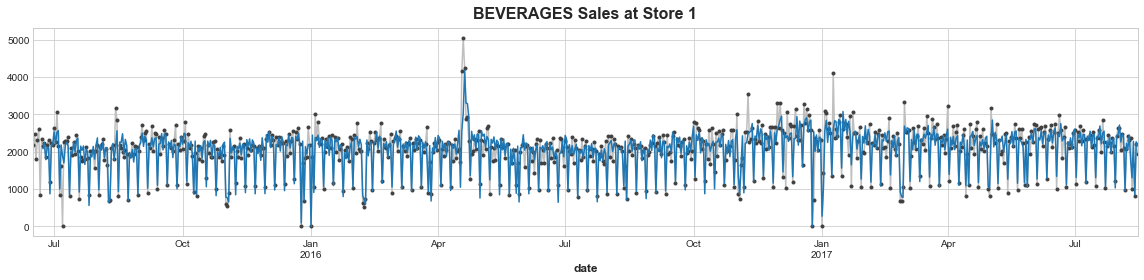

In [55]:
# see how the model fits entire training data set (except for first n dates where max_lag=n)
# for a specific store/family combination

STORE_NBR = '1'  # 1 - 54
FAMILY = 'BEVERAGES' # display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)[STORE_NBR, FAMILY].plot(**plot_params, figsize=(16, 4))
ax = y_pred.loc(axis=1)[STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

In [56]:
# train/val split prep that is the same for any of the hybrid forecasting methods

training_days = (train_end_day - train_start_day).days + 1
validation_days = (val_end_day - val_start_day).days + 1
print("training data set (excluding validation days) has", training_days, "days")
print("validation data set has", validation_days, "days\n")

store_sales_in_date_range = store_sales.unstack(['store_nbr', 'family']).loc[train_start_day:train_end_day]
store_data_in_val_range = store_sales.unstack(['store_nbr', 'family']).loc[val_start_day:val_end_day]
y_val = y[val_start_day:val_end_day] # use y to evaluate validation set, though we will treat y as unknown when training

model_for_val = BoostedHybrid(model_1=mod_1, model_2=mod_2)

training data set (excluding validation days) has 776 days
validation data set has 16 days



In [57]:
%%time

# DIRECT hybrid version of train/validate (can't use with lagged/rolling features on y, promo, etc.)
if hybrid_forecasting_type == "direct":
    X_1_train, y_train, dp_val = make_X1_features(store_sales_in_date_range, train_start_day, train_end_day) # preparing X1 for hybrid part 1: LinearRegression
    model_for_val.fit1(X_1_train, y_train, stack_cols=['store_nbr', 'family']) # fit1 before make_X2_features, since X2 may want to create lag features from model.y_resid
    X_2_train = make_X2_features(store_sales_in_date_range
                           .drop('sales', axis=1)
                           .stack(['store_nbr', 'family']),
                           model_for_val.y_resid) # preparing X2 for hybrid part 2: XGBoost
    model_for_val.fit2(X_2_train, max_lag, stack_cols=['store_nbr', 'family'])

    X_1_val = make_X1_features(dp_val.out_of_sample(steps=validation_days), val_start_day, val_end_day, is_test_set=True)
    X_2_val = make_X2_features(store_data_in_val_range
                                .drop('sales', axis=1)
                                .stack(['store_nbr', 'family']),
                                model_for_val.y_resid) # preparing X2 for hybrid part 2: XGBoost
    y_fit = model_for_val.predict(X_1_train, X_2_train, max_lag).clip(0.0)
    y_pred = model_for_val.predict(X_1_val, X_2_val, 0).clip(0.0) # set max_lag to 0 because need entire time span for validation data set
    
    if type(model_for_val.model_2) == XGBRegressor:
        pickle.dump(model_for_val.model_2, open("xgb_temp.pkl", "wb"))
        m2 = pickle.load(open("xgb_temp.pkl", "rb"))
        print("XGBRegressor paramaters:\n",m2.get_xgb_params(), "\n")

Wall time: 0 ns


In [58]:
%%time

# forecast 1 day at a time which allows use of lag features. Slow.
# Each new day y is fixed after it's initial prediction - no y row is ever predicted more than once
if hybrid_forecasting_type == "day_by_day_fixed_past":
    #initial fit on train portion of train/val split
    X_1_train, y_train, dp_val = make_X1_features(store_sales_in_date_range, train_start_day, train_end_day) # preparing X1 for hybrid part 1: LinearRegression
    model_for_val.fit1(X_1_train, y_train, stack_cols=['store_nbr', 'family']) # fit1 before make_X2_features, since X2 may want to create lag features from model.y_resid
    X_2_train = make_X2_features(store_sales_in_date_range
                           .drop('sales', axis=1)
                           .stack(['store_nbr', 'family']),
                           model_for_val.y_resid) # preparing X2 for hybrid part 2: XGBoost
    model_for_val.fit2(X_2_train, max_lag, stack_cols=['store_nbr', 'family'])
    y_fit = model_for_val.predict(X_1_train, X_2_train, max_lag).clip(0.0)

    y_pred_combined = y_fit.copy() # initialize y_pred_combined

    # loop through forecast, one day ("step") at a time
    dp_for_full_X1_val_date_range = dp_val.out_of_sample(steps=validation_days)
    for step in range(validation_days):
        dp_steps_so_far = dp_for_full_X1_val_date_range.loc[val_start_day:val_start_day+pd.Timedelta(days=step),:]

        X_1_combined_dp_data = pd.concat([dp_val.in_sample(), dp_steps_so_far])
        X_2_combined_data = pd.concat([store_sales_in_date_range,
                                       store_data_in_val_range.loc[val_start_day:val_start_day+pd.Timedelta(days=step), :]])
        X_1_val = make_X1_features(X_1_combined_dp_data, train_start_day, val_start_day+pd.Timedelta(days=step), is_test_set=True)
        X_2_val = make_X2_features(X_2_combined_data
                                    .drop('sales', axis=1)
                                    .stack(['store_nbr', 'family']),
                                    model_for_val.y_resid) # preparing X2 for hybrid part 2: XGBoost

    #     print("last 3 rows of X_1_val: ")
    #     display(X_1_val.tail(3))
    #     temp_val2 = X_2_val[(X_2_val.store_nbr == 1) & (X_2_val.family == 3)]
    #     print("last 3 rows of X_2_val: ")
    #     display(temp_val2.tail(3).apply(lambda s: truncateFloat(s)))

        y_pred_combined = pd.concat([y_pred_combined,
                                     model_for_val.predict(X_1_val, X_2_val, max_lag).clip(0.0).iloc[-1:]
                                    ])
    #     print("last 3 rows of y_combined: ")
    #     display(y_pred_combined.tail(3).apply(lambda s: truncateFloat(s)))
        y_plus_y_val = pd.concat([y_train, y_pred_combined.iloc[-(step+1):]]) # add newly predicted rows of y_pred_combined
        model_for_val.fit1(X_1_val, y_plus_y_val, stack_cols=['store_nbr', 'family']) # fit on new combined X, y - note that fit prior to val date range will change slightly
        model_for_val.fit2(X_2_val, max_lag, stack_cols=['store_nbr', 'family'])

        rmsle_valid = mean_squared_log_error(y_val.iloc[step:step+1], y_pred_combined.iloc[-1:]) ** 0.5
        print(f'Validation RMSLE: {rmsle_valid:.5f}', "for", val_start_day+pd.Timedelta(days=step))

    y_pred = y_pred_combined[val_start_day:val_end_day]
    print("\ny_pred: ")
    display(y_pred.apply(lambda s: truncateFloat(s)))
    
    if type(model_for_val.model_2) == XGBRegressor:
        pickle.dump(model_for_val.model_2, open("xgb_temp.pkl", "wb"))
        m2 = pickle.load(open("xgb_temp.pkl", "rb"))
        print("XGBRegressor paramaters:\n",m2.get_xgb_params(), "\n")

Wall time: 0 ns


In [59]:
%%time
# forecast 1 day at a time which allows use of lag features. Slow.
# each new forecast causes y for all days in training and test (or validation set) to be reforecast.
if hybrid_forecasting_type == "day_by_day_refit_all_days":
    #initial fit on train portion of train/val split
    X_1_train, y_train, dp_val = make_X1_features(store_sales_in_date_range, train_start_day, train_end_day) # preparing X1 for hybrid part 1: LinearRegression
    model_for_val.fit1(X_1_train, y_train, stack_cols=['store_nbr', 'family']) # fit1 before make_X2_features, since X2 may want to create lag features from model.y_resid
    X_2_train = make_X2_features(store_sales_in_date_range
                           .drop('sales', axis=1)
                           .stack(['store_nbr', 'family']),
                           model_for_val.y_resid) # preparing X2 for hybrid part 2: XGBoost
    model_for_val.fit2(X_2_train, max_lag, stack_cols=['store_nbr', 'family'])
    y_fit = model_for_val.predict(X_1_train, X_2_train, max_lag).clip(0.0)

    # loop through forecast, one day ("step") at a time
    dp_for_full_X1_val_date_range = dp_val.out_of_sample(steps=validation_days)
    for step in range(validation_days):
        dp_steps_so_far = dp_for_full_X1_val_date_range.loc[val_start_day:val_start_day+pd.Timedelta(days=step),:]

        X_1_combined_dp_data = pd.concat([dp_val.in_sample(), dp_steps_so_far])
        X_2_combined_data = pd.concat([store_sales_in_date_range,
                                       store_data_in_val_range.loc[val_start_day:val_start_day+pd.Timedelta(days=step), :]])
        X_1_val = make_X1_features(X_1_combined_dp_data, train_start_day, val_start_day+pd.Timedelta(days=step), is_test_set=True)
        X_2_val = make_X2_features(X_2_combined_data
                                    .drop('sales', axis=1)
                                    .stack(['store_nbr', 'family']),
                                    model_for_val.y_resid) # preparing X2 for hybrid part 2: XGBoost

    #     print("last 3 rows of X_1_val: ")
    #     display(X_1_val.tail(3))
    #     temp_val2 = X_2_val[(X_2_val.store_nbr == 1) & (X_2_val.family == 3)]
    #     print("last 3 rows of X_2_val: ")
    #     display(temp_val2.tail(3).apply(lambda s: truncateFloat(s)))

        y_pred_combined = model_for_val.predict(X_1_val, X_2_val, max_lag).clip(0.0) # generate y with 
    #     print("last 3 rows of y_combined: ")
    #     display(y_pred_combined.tail(3).apply(lambda s: truncateFloat(s)))
        y_plus_y_val = pd.concat([y_train, y_pred_combined.iloc[-(step+1):]]) # add newly predicted rows of y_pred_combined
        model_for_val.fit1(X_1_val, y_plus_y_val, stack_cols=['store_nbr', 'family']) # fit on new combined X, y - note that fit prior to val date range will change slightly
        model_for_val.fit2(X_2_val, max_lag, stack_cols=['store_nbr', 'family'])

        rmsle_valid = mean_squared_log_error(y_val.iloc[step:step+1], y_pred_combined.iloc[-1:]) ** 0.5
        print(f'Validation RMSLE: {rmsle_valid:.5f}', "for", val_start_day+pd.Timedelta(days=step))
    #     print("end of round ", step)

    y_pred = y_pred_combined[val_start_day:val_end_day]
    print("\ny_pred: ")
    display(y_pred.apply(lambda s: truncateFloat(s)))
    
    if type(model_for_val.model_2) == XGBRegressor:
        pickle.dump(model_for_val.model_2, open("xgb_temp.pkl", "wb"))
        m2 = pickle.load(open("xgb_temp.pkl", "rb"))
        print("XGBRegressor paramaters:\n",m2.get_xgb_params(), "\n")

Validation RMSLE: 0.53433 for 2017-07-31 00:00:00
Validation RMSLE: 0.69065 for 2017-08-01 00:00:00
Validation RMSLE: 0.50192 for 2017-08-02 00:00:00
Validation RMSLE: 0.49207 for 2017-08-03 00:00:00
Validation RMSLE: 0.48932 for 2017-08-04 00:00:00
Validation RMSLE: 0.45249 for 2017-08-05 00:00:00
Validation RMSLE: 0.48244 for 2017-08-06 00:00:00
Validation RMSLE: 0.48194 for 2017-08-07 00:00:00
Validation RMSLE: 0.49575 for 2017-08-08 00:00:00
Validation RMSLE: 0.46997 for 2017-08-09 00:00:00
Validation RMSLE: 0.54804 for 2017-08-10 00:00:00
Validation RMSLE: 0.53410 for 2017-08-11 00:00:00
Validation RMSLE: 0.53139 for 2017-08-12 00:00:00
Validation RMSLE: 0.54027 for 2017-08-13 00:00:00
Validation RMSLE: 0.50380 for 2017-08-14 00:00:00
Validation RMSLE: 0.50093 for 2017-08-15 00:00:00

y_pred: 


store_nbr           1                                                \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-07-31       3.74      0.00   3.67   2441.74  0.12       403.42   
2017-08-01       8.50      3.47   7.75   2500.65  4.16       399.80   
2017-08-02       5.05      0.00   6.81   2673.96  0.69       453.01   
2017-08-03       4.02      0.00   6.43   2251.97  0.04       391.91   
2017-08-04       5.03      0.00   6.31   2535.59  0.13       422.90   
2017-08-05       4.93      0.00   6.38   2480.67  0.03       398.72   
2017-08-06       1.69      0.00   4.68   1118.60  0.00       151.37   
2017-08-07       3.88      0.00   6.29   2290.71  0.10       417.24   
2017-08-08       4.32      0.00   8.07   2206.75  0.20       384.92   
2017-08-09       4.08      0.00   8.33   2441.98  0.26       455.72   
2017-08-10       3.69      0.00   7.16   1810.54  0.00       342.96   
2017-08-11       1.66      0.00   6.66   1203.82  0.00       195.54   
2017-08-12       4.51      0.00   8.02   2395.19  0.26       411.48   
2017-08-13       1.48      0.00   4.03   1082.50  0.18       164.93   
2017-08-14       3.85      0.00   7.85   2299.04  0.31       427.24   
2017-08-15       4.37      0.00   7.83   2213.75  0.35       395.94   

store_nbr                                        ...         9          \
family     CELEBRATION CLEANING   DAIRY    DELI  ... MAGAZINES   MEATS   
date                                             ...                     
2017-07-31       13.68   737.98  731.56  156.24  ...      2.33  423.98   
2017-08-01       20.01   833.10  730.65  169.39  ...      6.63  452.53   
2017-08-02       18.39   948.44  879.59  153.48  ...      3.61  457.79   
2017-08-03       18.70   752.23  694.11  126.77  ...      2.88  621.95   
2017-08-04       22.91   827.43  845.04  179.53  ...      2.87  373.89   
2017-08-05       13.16   669.95  814.89  137.97  ...      4.28  474.36   
2017-08-06        3.59   263.65  348.79   47.29  ...      4.84  502.45   
2017-08-07       13.86   683.10  759.05  140.13  ...      1.95  396.14   
2017-08-08       16.05   686.46  744.94  130.59  ...      2.50  368.09   
2017-08-09       18.65   799.00  895.15  142.81  ...      2.69  345.68   
2017-08-10       18.23   572.06  657.22  105.71  ...      2.57  490.65   
2017-08-11        7.55   254.93  393.89   68.87  ...      4.40  383.76   
2017-08-12       14.53   573.84  806.27  131.20  ...      5.24  396.10   
2017-08-13        4.18   191.59  363.11   48.40  ...      5.93  436.20   
2017-08-14       14.19   641.34  784.81  139.78  ...      3.00  356.90   
2017-08-15       16.03   678.63  761.79  131.36  ...      3.41  351.16   

store_nbr                                                              \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2017-07-31        535.01         8.10                   10.20  446.30   
2017-08-01        658.36        11.96                   18.59  486.39   
2017-08-02        623.32         9.35                   10.19  467.24   
2017-08-03        604.91         8.11                   10.87  466.65   
2017-08-04        519.98         7.57                    8.61  528.33   
2017-08-05        734.26         9.86                   14.33  595.06   
2017-08-06        769.55        10.68                   16.10  653.96   
2017-08-07        505.91         6.47                    8.82  406.02   
2017-08-08        467.75         5.97                    7.76  373.04   
2017-08-09        391.63         6.42                    6.42  324.41   
2017-08-10        328.02         5.34                    8.57  319.74   
2017-08-11        561.62         7.89                   14.90  567.47   
2017-08-12        525.63         8.60                   12.32  527.79   
2017-08-13        609.50        10.09                   14.53  623.78   
20

XGBRegressor paramaters:
 {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'monotone_constraints': '()', 'n_jobs': 8, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None} 

Wall time: 53min 48s


In [60]:
rmsle_train = mean_squared_log_error(y_train.iloc[max_lag: , :].clip(0.0), y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_val.clip(0.0), y_pred) ** 0.5
print()
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')
    
y_predict = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y_val.stack(['store_nbr', 'family']).reset_index().copy()
y_target.rename(columns={y_target.columns[3]:'sales'}, inplace=True)
y_target['sales_pred'] = y_predict[0].clip(0.0) # Sales should be >= 0
y_target['store_nbr'] = y_target['store_nbr'].astype(int)

print('\nValidation RMSLE by family')
display(y_target.groupby('family').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred'])))

print('\nValidation RMSLE by store')
display(y_target.sort_values(by="store_nbr").groupby('store_nbr').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred'])))


Training RMSLE: 0.61016
Validation RMSLE: 0.51079

Validation RMSLE by family


family
AUTOMOTIVE                    0.298889
BABY CARE                     0.220219
BEAUTY                        0.405183
BEVERAGES                     0.057221
BOOKS                         0.206273
BREAD/BAKERY                  0.044300
CELEBRATION                   0.345950
CLEANING                      0.104804
DAIRY                         0.033094
DELI                          0.039587
EGGS                          0.115633
FROZEN FOODS                  0.201601
GROCERY I                     0.031513
GROCERY II                    0.346567
HARDWARE                      0.386628
HOME AND KITCHEN I            0.306117
HOME AND KITCHEN II           0.322925
HOME APPLIANCES               0.257143
HOME CARE                     0.060907
LADIESWEAR                    0.396090
LAWN AND GARDEN               0.303826
LINGERIE                      0.514422
LIQUOR,WINE,BEER              0.364714
MAGAZINES                     0.316745
MEATS                         0.190120
PERSONAL CARE     


Validation RMSLE by store


store_nbr
1     0.181119
2     0.177888
3     0.169029
4     0.164704
5     0.195014
6     0.142605
7     0.135428
8     0.149686
9     0.283540
10    0.233190
11    0.217439
12    0.220560
13    0.222540
14    0.269887
15    0.249738
16    0.344851
17    0.225158
18    0.265840
19    0.303813
20    0.301603
21    0.291635
22    0.326657
23    0.247882
24    0.203442
25    0.320690
26    0.369436
27    0.169303
28    0.253579
29    0.199000
30    0.268892
31    0.248995
32    0.400644
33    0.300798
34    0.310675
35    0.283751
36    0.422792
37    0.159755
38    0.239110
39    0.445167
40    0.285232
41    0.202719
42    0.246534
43    0.266166
44    0.399296
45    0.156388
46    0.127926
47    0.457583
48    0.359334
49    0.178126
50    0.478836
51    0.234734
52    0.206651
53    0.304131
54    0.269380
dtype: float64

In [61]:
train_days = (full_train_end_day - full_train_start_day).days + 1
test_days = (test_end_day - test_start_day).days + 1

print("data trained over", train_days, "days")
print("test forecasting period is", test_days, "days through", test_end_day, "\n")
store_sales_in_date_range = store_sales.unstack(['store_nbr', 'family']).loc[full_train_start_day:full_train_end_day]
store_data_in_test_range = df_test.unstack(['store_nbr', 'family']).drop('id', axis=1)

# previously prepared data and fit "model" from data ranging from full_train_start_day to full_train_end_day. Can be used by when fitting test.
model_for_test = BoostedHybrid(model_1=mod_1, model_2=mod_2)

data trained over 792 days
test forecasting period is 16 days through 2017-08-31 00:00:00 



In [62]:
%%time
# DIRECT hybrid version of train/validate (can't use with lagged/rolling features on y, promo, etc.)
# model.fit (1 and 2) already happened previously (on training set with a time range ending on most recent date)

if hybrid_forecasting_type == "direct":
    X_1_test = make_X1_features(dp.out_of_sample(steps=int(test_days)), test_start_day, test_end_day, is_test_set=True)
    X_2_test = make_X2_features(store_data_in_test_range.loc[test_start_day:test_end_day]
                                .stack(['store_nbr', 'family']),
                                model.y_resid) # preparing X2 for hybrid part 2: XGBoost
    y_forecast = pd.DataFrame(model.predict(X_1_test, X_2_test, 0).clip(0.0), index=X_1_test.index, columns=y.columns) # set max_lag to 0 because need entire time span for test data set
    
    if type(model.model_2) == XGBRegressor:
        pickle.dump(model.model_2, open("xgb_temp.pkl", "wb"))
        m2 = pickle.load(open("xgb_temp.pkl", "rb"))
        print("XGBRegressor paramaters:\n",m2.get_xgb_params(), "\n")

Wall time: 0 ns


In [63]:
%%time
# forecast 1 day at a time which allows use of lag features. Slow.
# Each new day y is fixed after it's initial prediction - no y row is ever predicted more than once
if hybrid_forecasting_type == "day_by_day_fixed_past":
    #initial fit on train portion of train/test split
    X_1_train, y_train, dp_test = make_X1_features(store_sales_in_date_range, full_train_start_day, full_train_end_day) # preparing X1 for hybrid part 1: LinearRegression
    model_for_test.fit1(X_1_train, y_train, stack_cols=['store_nbr', 'family']) # fit1 before make_X2_features, since X2 may want to create lag features from model.y_resid
    X_2_train = make_X2_features(store_sales_in_date_range
                           .drop('sales', axis=1)
                           .stack(['store_nbr', 'family']),
                           model_for_test.y_resid) # preparing X2 for hybrid part 2: XGBoost
    model_for_test.fit2(X_2_train, max_lag, stack_cols=['store_nbr', 'family'])

    y_forecast_combined = model_for_test.predict(X_1_train, X_2_train, max_lag).clip(0.0) # initializing with training set fit

    dp_for_full_X1_test_date_range = dp_test.out_of_sample(steps=test_days)
    for step in range(test_days):
        dp_steps_so_far = dp_for_full_X1_test_date_range.loc[test_start_day:test_start_day+pd.Timedelta(days=step),:]

        X_1_combined_dp_data = pd.concat([dp_test.in_sample(), dp_steps_so_far])
        X_2_combined_data = pd.concat([store_sales_in_date_range,
                                       store_data_in_test_range.loc[test_start_day:test_start_day+pd.Timedelta(days=step), :]])
        X_1_test = make_X1_features(X_1_combined_dp_data, train_start_day, test_start_day+pd.Timedelta(days=step), is_test_set=True)
        X_2_test = make_X2_features(X_2_combined_data
                                    .drop('sales', axis=1)
                                    .stack(['store_nbr', 'family']),
                                    model_for_test.y_resid) # preparing X2 for hybrid part 2: XGBoost
    #     print("last 3 rows of X_1_test: ")
    #     display(X_1_test.tail(3))
    #     temp_test2 = X_2_test[(X_2_test.store_nbr == 1) & (X_2_test.family == 3)]
    #     print("last 3 rows of X_2_test: ")
    #     display(temp_test2.tail(3).apply(lambda s: truncateFloat(s)))

        y_forecast_combined = pd.concat([y_forecast_combined,
                                     model_for_test.predict(X_1_test, X_2_test, max_lag).clip(0.0).iloc[-1:]
                                    ])   
    #     print("last 3 rows of y_forecast_combined: ")
    #     display(y_forecast_combined.tail(3).apply(lambda s: truncateFloat(s)))

        y_plus_y_test = pd.concat([y_train, y_forecast_combined.iloc[-(step+1):]]) # add newly predicted (last step+1) rows of y_test_combined
        model_for_test.fit1(X_1_test, y_plus_y_test, stack_cols=['store_nbr', 'family']) # fit on new combined X, y - note that fit prior to test date range will change slightly
        model_for_test.fit2(X_2_test, max_lag, stack_cols=['store_nbr', 'family'])
        print("finished forecast for", test_start_day+pd.Timedelta(days=step))

    display(y_forecast_combined[test_start_day:test_end_day])
    y_forecast = pd.DataFrame(y_forecast_combined[test_start_day:test_end_day].clip(0.0), index=X_1_test.index, columns=y.columns)
    print('\nFinished creating test set forecast\n')
    
    if type(model_for_test.model_2) == XGBRegressor:
        pickle.dump(model_for_test.model_2, open("xgb_temp.pkl", "wb"))
        m2 = pickle.load(open("xgb_temp.pkl", "rb"))
        print("XGBRegressor paramaters:\n",m2.get_xgb_params(), "\n")

Wall time: 999 µs


In [64]:
%%time

# forecast 1 day at a time which allows use of lag features. Slow.
# each new forecast causes y for all days in training and test (or validation set) to be reforecast.
if hybrid_forecasting_type == "day_by_day_refit_all_days":
    #initial fit on train portion of train/test split
    X_1_train, y_train, dp_test = make_X1_features(store_sales_in_date_range, full_train_start_day, full_train_end_day) # preparing X1 for hybrid part 1: LinearRegression
    model_for_test.fit1(X_1_train, y_train, stack_cols=['store_nbr', 'family']) # fit1 before make_X2_features, since X2 may want to create lag features from model.y_resid
    X_2_train = make_X2_features(store_sales_in_date_range
                           .drop('sales', axis=1)
                           .stack(['store_nbr', 'family']),
                           model_for_test.y_resid) # preparing X2 for hybrid part 2: XGBoost
    model_for_test.fit2(X_2_train, max_lag, stack_cols=['store_nbr', 'family'])
    # y_full_train = model_for_test.predict(X_1_train, X_2_train, max_lag).clip(0.0) # do I need this line here?


    dp_for_full_X1_test_date_range = dp_test.out_of_sample(steps=test_days)
    for step in range(test_days):
        dp_steps_so_far = dp_for_full_X1_test_date_range.loc[test_start_day:test_start_day+pd.Timedelta(days=step),:]

        X_1_combined_dp_data = pd.concat([dp_test.in_sample(), dp_steps_so_far])
        X_2_combined_data = pd.concat([store_sales_in_date_range,
                                       store_data_in_test_range.loc[test_start_day:test_start_day+pd.Timedelta(days=step), :]])
        X_1_test = make_X1_features(X_1_combined_dp_data, train_start_day, test_start_day+pd.Timedelta(days=step), is_test_set=True)
        X_2_test = make_X2_features(X_2_combined_data
                                    .drop('sales', axis=1)
                                    .stack(['store_nbr', 'family']),
                                    model_for_test.y_resid) # preparing X2 for hybrid part 2: XGBoost
    #     print("last 3 rows of X_1_test: ")
    #     display(X_1_test.tail(3))
    #     temp_test2 = X_2_test[(X_2_test.store_nbr == 1) & (X_2_test.family == 3)]
    #     print("last 3 rows of X_2_test: ")
    #     display(temp_test2.tail(3).apply(lambda s: truncateFloat(s)))

        y_forecast_combined = model_for_test.predict(X_1_test, X_2_test, max_lag).clip(0.0) # generate y with 

    #     print("last 3 rows of y_forecast_combined: ")
    #     display(y_forecast_combined.tail(3).apply(lambda s: truncateFloat(s)))

        y_plus_y_test = pd.concat([y_train, y_forecast_combined.iloc[-(step+1):]]) # add newly predicted (last step+1) rows of y_test_combined
        model_for_test.fit1(X_1_test, y_plus_y_test, stack_cols=['store_nbr', 'family']) # fit on new combined X, y - note that fit prior to test date range will change slightly
        model_for_test.fit2(X_2_test, max_lag, stack_cols=['store_nbr', 'family'])
        print("finished forecast for", test_start_day+pd.Timedelta(days=step))

    display(y_forecast_combined[test_start_day:test_end_day])

    y_forecast = pd.DataFrame(y_forecast_combined[test_start_day:test_end_day].clip(0.0), index=X_1_test.index, columns=y.columns)
    print('\nFinished creating test set forecast\n')
    
    if type(model_for_test.model_2) == XGBRegressor:
        pickle.dump(model_for_test.model_2, open("xgb_temp.pkl", "wb"))
        m2 = pickle.load(open("xgb_temp.pkl", "rb"))
        print("XGBRegressor paramaters:\n",m2.get_xgb_params(), "\n")

finished forecast for 2017-08-16 00:00:00
finished forecast for 2017-08-17 00:00:00
finished forecast for 2017-08-18 00:00:00
finished forecast for 2017-08-19 00:00:00
finished forecast for 2017-08-20 00:00:00
finished forecast for 2017-08-21 00:00:00
finished forecast for 2017-08-22 00:00:00
finished forecast for 2017-08-23 00:00:00
finished forecast for 2017-08-24 00:00:00
finished forecast for 2017-08-25 00:00:00
finished forecast for 2017-08-26 00:00:00
finished forecast for 2017-08-27 00:00:00
finished forecast for 2017-08-28 00:00:00
finished forecast for 2017-08-29 00:00:00
finished forecast for 2017-08-30 00:00:00
finished forecast for 2017-08-31 00:00:00


store_nbr           1                                                          \
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-08-16   6.254553  1.631319  8.625835  2504.931292  2.435234   437.595126   
2017-08-17   4.524726  0.646294  6.396941  2127.209680  1.262458   371.997997   
2017-08-18   4.128892  0.000000  6.363416  2446.283244  0.000000   406.340104   
2017-08-19   4.098592  0.000000  6.405137  2434.314553  0.000000   384.367815   
2017-08-20   1.079129  0.000000  4.697117  1122.300736  0.000000   149.765068   
2017-08-21   4.412589  0.132780  6.655461  2321.186138  0.815930   401.312053   
2017-08-22   5.014219  0.619397  4.276829  2170.633661  0.863322   376.255097   
2017-08-23   4.972242  0.159669  7.048654  2472.556569  0.926280   441.071732   
2017-08-24   4.295620  0.141795  4.539128  2048.488966  0.733552   370.723576   
2017-08-25   4.386791  0.000000  4.590455  2369.268734  0.000000   399.212152   
2017-08-26   4.262098  0.000000  7.018984  2308.321746  0.000000   373.046135   
2017-08-27   1.081955  0.000000  5.258455   965.162987  0.000000   131.888774   
2017-08-28   4.247658  0.135687  6.735899  2186.124672  0.655968   398.304695   
2017-08-29   4.743743  0.136476  6.626300  2207.350635  0.706810   368.573804   
2017-08-30   4.713560  0.159995  4.648403  2450.026404  0.810617   441.866199   
2017-08-31   4.185639  0.141144  6.929999  2169.431608  0.685152   383.727850   

store_nbr                                                   ...         9  \
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2017-08-16   19.258360  866.985637  987.925526  176.129374  ...  5.779359   
2017-08-17   18.079817  668.006630  686.601596  130.265215  ...  4.511375   
2017-08-18   22.060024  743.715631  809.224848  183.752128  ...  4.943321   
2017-08-19   12.520644  586.562456  787.934745  140.361408  ...  6.571934   
2017-08-20    2.449177  168.623633  374.493891   54.360978  ...  7.062572   
2017-08-21   13.264805  639.085701  799.894115  147.898262  ...  4.310778   
2017-08-22   15.898801  659.893790  746.535661  136.947235  ...  4.319979   
2017-08-23   17.736673  776.916279  912.307037  146.484781  ...  4.063961   
2017-08-24   16.607338  615.728427  692.513419  122.339338  ...  3.455120   
2017-08-25   20.597780  677.470584  793.264988  175.641081  ...  2.922868   
2017-08-26   11.631590  517.098636  742.397201  131.298294  ...  4.652078   
2017-08-27    1.497121  133.438304  276.884110   42.398793  ...  5.411215   
2017-08-28   12.528875  585.079905  704.342123  139.446891  ...  3.497150   
2017-08-29   14.741153  633.243722  678.669865  132.274633  ...  3.873558   
2017-08-30   17.210096  772.267049  876.620884  149.003086  ...  3.817994   
2017-08-31   17.652062  666.170464  690.150465  131.742056  ...  3.872013   

store_nbr                                                                  \
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-08-16  365.252583    429.277234     8.225082                8.437123   
2017-08-17  508.909468    362.896356     7.618045                8.788433   
2017-08-18  292.871355    314.192734     5.144645                5.663188   
2017-08-19  407.535782    591.089523     7.840145               12.948503   
2017-08-20  445.747106    657.716243     9.000569               14.627627   
2017-08-21  358.852759    427.620791     6.983230                8.948986   
2017-08-22  337.698458    401.722052     6.783493                8.408798   
2017-08-23  320.514938    336.972256     7.636747                7.799989   
2017-08-24  472.225298    310.827835     7.237215                9.115006   
2017-08-25  265.925511    246.577733     6.255003                6.45612


Finished creating test set forecast

XGBRegressor paramaters:
 {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'monotone_constraints': '()', 'n_jobs': 8, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None} 

Wall time: 57min 23s


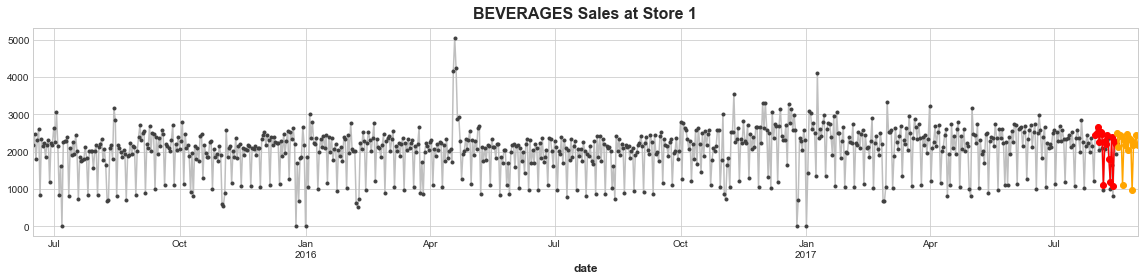

In [65]:
# see example predictions (both validation and test data sets) for a specific store/family:

STORE_NBR = '1'  # 1 - 54
FAMILY = 'BEVERAGES' # display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)[STORE_NBR, FAMILY].plot(**plot_params, figsize=(16, 4))
ax = y_pred.loc(axis=1)[STORE_NBR, FAMILY].plot(ax=ax, marker='.', color='red', markersize=12) # markers: big size for tiny validation sets (1-2 days)
ax = y_forecast.loc(axis=1)[STORE_NBR, FAMILY].plot(ax=ax, marker='.', color='orange', markersize=12)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

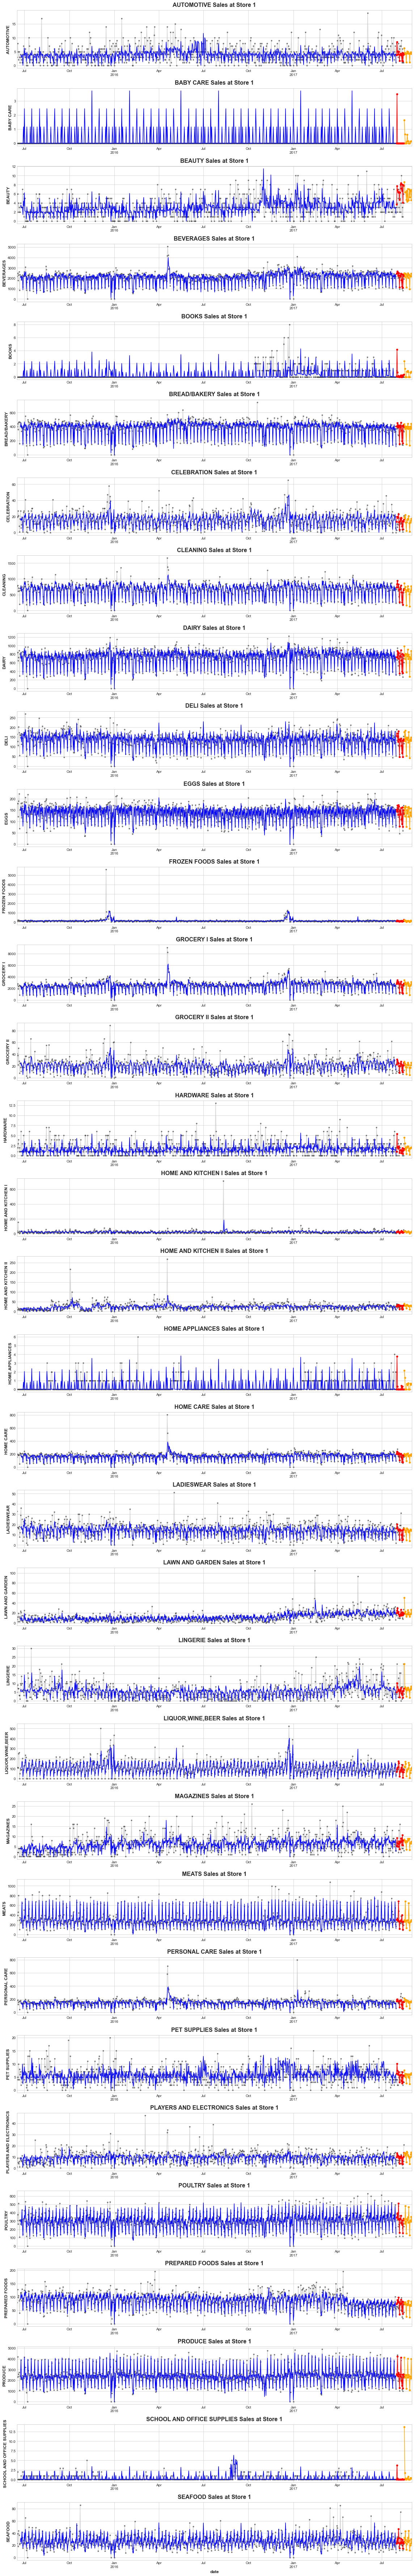

In [66]:
# See:
# 1) sales(y) - grey
# 2) sales prediction on training set (y_fit) - blue
# 3) sales prediction on validation set (y_pred) - red
# 4) sales prediction on test set (y_forecast) - orange
# for first n families of a single store where 1 <= n <= 33
# NUM_FAMILIES = 2 gives you first 2 (Automotive and Baby Care)
# NUM_FAMILIES = 33 gives you all families (Automotive through Seafood)

NUM_FAMILIES = 33   # 1 - 33
STORE_NBR = '1'    # 1 - 54

y_for_one_store = y.loc(axis=1)[STORE_NBR]
y_fit_for_one_store = y_fit.loc(axis=1)[STORE_NBR]
y_pred_for_one_store = y_pred.loc(axis=1)[STORE_NBR]
y_forecast_for_one_store = y_forecast.loc(axis=1)[STORE_NBR]
families = y_for_one_store.columns[0:NUM_FAMILIES]

axs = y_for_one_store.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(16, 3*NUM_FAMILIES), **plot_params, alpha=0.6,
)
_ = y_fit_for_one_store.loc(axis=1)[families].plot(subplots=True, sharex=True, color='blue', ax=axs)
_ = y_pred_for_one_store.loc(axis=1)[families].plot(subplots=True, sharex=True, color='red', ax=axs, marker='.', markersize=9) # markers: for tiny validation sets (1-2 days)
_ = y_forecast_for_one_store.loc(axis=1)[families].plot(subplots=True, sharex=True, color='orange', ax=axs, marker='.', markersize=9)

for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)
    ax.set_title(f'{family} Sales at Store {STORE_NBR}')
    ax.tick_params(labelbottom=True) # gets x-axis labeled under EVERY plot - without this it's just the bottom one
    
# blue = fit, red = predict (for validation range), orange = submission forecast

In [67]:
# creates submission file submission.csv

y_submit = y_forecast.stack(['store_nbr', 'family'])
y_submit = pd.DataFrame(y_submit, columns=['sales'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)